#### This code is originally taken from 
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ 

In [1]:
import numpy as np
from math import sqrt
from numpy import concatenate
from datetime import datetime
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [4]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [5]:
dataset.drop(['wnd_dir'], axis=1, inplace=True)

In [6]:
dataset.head()

,pollution,dew,temp,press,wnd_spd,snow,rain
date,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0


In [7]:
# ensure all data is float
values = dataset.values.astype('float64') # 'float32'

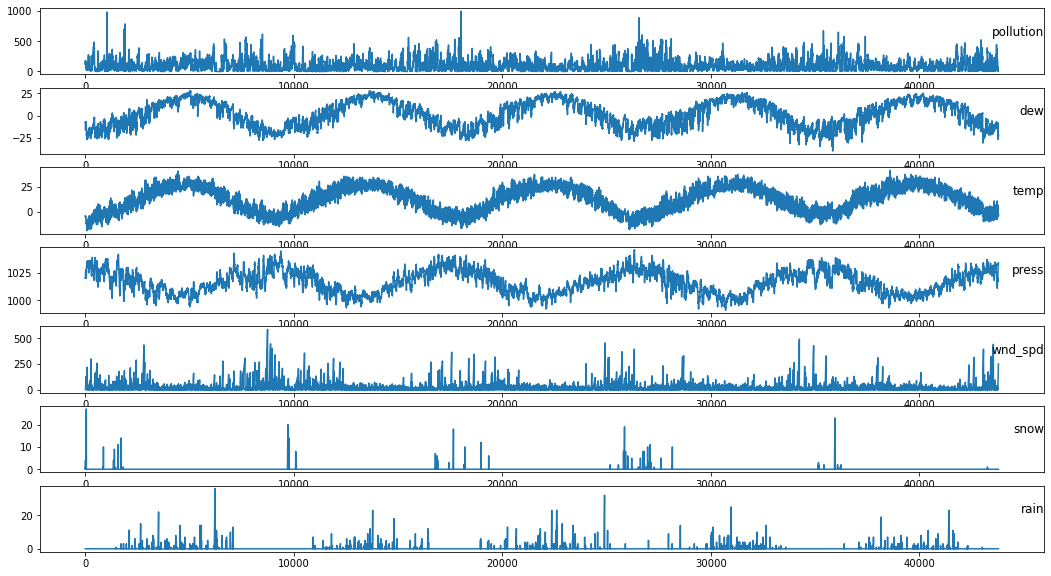

In [8]:
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
plt.figure(figsize=(18,10))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [9]:
# scaling function 
def MinMax(data):
    data = data.reshape(-1,1)
    return (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

# inverting scaling
def UnMinMax(inv_data, data):
    data = data.reshape(-1,1)
    inv_data = inv_data.reshape(-1,1)
    return inv_data * (data.max(axis=0) - data.min(axis=0)) + data.min(axis=0)

In [10]:
# show features 
print('Columns are:\n', *dataset.columns.values, sep= '\n')

Columns are:

pollution
dew
temp
press
wnd_spd
snow
rain


In [11]:
# extract features 
pollution = values[:,0]
dew = values[:,1]
temp = values[:,2]
press = values[:,3]
wnd_spd = values[:,4]
rain = values[:,5]

In [12]:
# normalize features 
n_pollution = MinMax(pollution)
n_dew = MinMax(dew)
n_temp = MinMax(temp)
n_press = MinMax(press)
n_wnd_spd = MinMax(wnd_spd)
n_rain = MinMax(rain)

# Assemble the normalized features 
scaled = np.concatenate([n_pollution.reshape(-1,1), 
                            n_dew.reshape(-1,1), 
                            n_temp.reshape(-1,1), 
                            n_press.reshape(-1,1), 
                            n_wnd_spd.reshape(-1,1), 
                            n_rain.reshape(-1,1)], axis=1)

In [13]:
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(43797, 24)


In [14]:
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
3,0.129779,0.352941,0.245902,0.527273,0.002290,0.000000,0.148893,0.367647,0.245902,0.527273,...,0.229508,0.545455,0.005332,0.000000,0.182093,0.485294,0.229508,0.563636,0.008391,0.037037
4,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.159960,0.426471,0.229508,0.545455,...,0.229508,0.563636,0.008391,0.037037,0.138833,0.485294,0.229508,0.563636,0.009912,0.074074
5,0.159960,0.426471,0.229508,0.545455,0.005332,0.000000,0.182093,0.485294,0.229508,0.563636,...,0.229508,0.563636,0.009912,0.074074,0.109658,0.485294,0.213115,0.563636,0.011433,0.111111
6,0.182093,0.485294,0.229508,0.563636,0.008391,0.037037,0.138833,0.485294,0.229508,0.563636,...,0.213115,0.563636,0.011433,0.111111,0.105634,0.485294,0.213115,0.581818,0.014492,0.148148
7,0.138833,0.485294,0.229508,0.563636,0.009912,0.074074,0.109658,0.485294,0.213115,0.563636,...,0.213115,0.581818,0.014492,0.148148,0.124748,0.485294,0.229508,0.600000,0.017551,0.000000


In [15]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [16]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(8760, 24) 8760 (8760,)


In [17]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


In [18]:
# design network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [19]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=256, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35037 samples
Epoch 1/100
 - 1s - loss: 0.0099 - val_loss: 0.0061
Epoch 2/100
 - 0s - loss: 0.0089 - val_loss: 0.0056
Epoch 3/100
 - 0s - loss: 0.0080 - val_loss: 0.0050
Epoch 4/100
 - 0s - loss: 0.0070 - val_loss: 0.0043
Epoch 5/100
 - 0s - loss: 0.0060 - val_loss: 0.0038
Epoch 6/100
 - 0s - loss: 0.0053 - val_loss: 0.0043
Epoch 7/100
 - 0s - loss: 0.0046 - val_loss: 0.0057
Epoch 8/100
 - 0s - loss: 0.0041 - val_loss: 0.0090
Epoch 9/100
 - 0s - loss: 0.0052 - val_loss: 0.0087
Epoch 10/100
 - 0s - loss: 0.0079 - val_loss: 0.0029
Epoch 11/100
 - 0s - loss: 0.0062 - val_loss: 0.0018
Epoch 12/100
 - 0s - loss: 0.0024 - val_loss: 6.8600e-04
Epoch 13/100
 - 0s - loss: 0.0019 - val_loss: 6.0174e-04
Epoch 14/100
 - 0s - loss: 0.0017 - val_loss: 6.8969e-04
Epoch 15/100
 - 0s - loss: 0.0016 - val_loss: 8.0852e-04
Epoch 16/100
 - 0s - loss: 0.0018 - val_loss: 8.8978e-04
Epoch 17/100
 - 0s - loss: 0.0018 - val_loss: 7.6738e-04
Epoch 18/100
 - 0s - loss: 0.0017 -

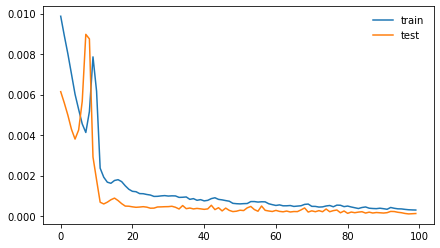

In [20]:
# plot history
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(loc=0, frameon=False)
plt.show()

In [21]:
# make a prediction
yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [22]:
# invert scaling for forecast
inv_yhat = UnMinMax(yhat, rain)

# inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]

In [23]:
# invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

In [24]:
# the actual target 
inv_y = rain[n_train_hours+n_hours:]

In [25]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.570


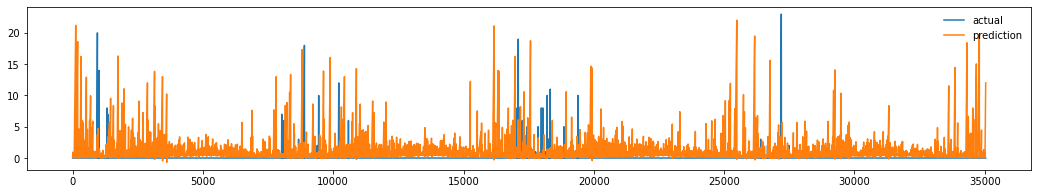

In [26]:
# plot comparison
plt.figure(figsize=(18,3))
plt.plot(inv_y, label='actual')
plt.plot(inv_yhat, label='prediction')
plt.legend(loc=0, frameon=False)
plt.show()

#### The next part is originally taken from 
https://www.kaggle.com/fatmakursun/time-series-forecasting-unknown-future/ 

In [27]:
def insert_end(Xin, new_input):
    for i in range(n_hours - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, n_hours-1, :] = new_input
    return Xin

In [28]:
test_X_forecast = test[:, :n_obs]
# reshape input to be 3D [samples, timesteps, features]
test_X_forecast = test_X_forecast.reshape((test_X_forecast.shape[0], n_hours, n_features))

In [29]:
# this section for unknown future 
first = 0
future = len(test_X_forecast) + 10000
forecast = []
Xin = test_X_forecast[first:first+1, :, :]
print(Xin.shape)

(1, 3, 8)


In [30]:
for i in range(future):
    out = model.predict(Xin, batch_size=1)
    forecast.append(out[0,0])
    Xin = insert_end(Xin, out[0,0])

print('Forecasting is completed')

Forecasting is completed


In [31]:
forcasted_output = np.asanyarray(forecast)
forcasted_output = forcasted_output.reshape(-1,1)

In [32]:
forcasted_output = UnMinMax(forcasted_output, inv_y)

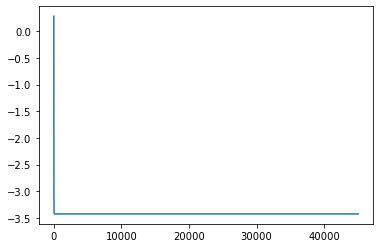

In [33]:
plt.plot(forcasted_output)